In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pytesseract
from skimage.filters import threshold_multiotsu
import imutils
from imutils import perspective
from imutils import contours
import cv2.cv2 as cv2
import argparse


### template matching

matching the shape of right angle and 'T' shape to find the tick; not very good, a lot of impurities in the image itself

In [ ]:
img=cv2.imread('/Users/livi/Git/Image-Processing/Bulk Spectra.tif',0)
template_angle=cv2.imread('/Users/livi/Git/Image-Processing/right angle.png',0)
template_T=cv2.imread('/Users/livi/Git/Image-Processing/T-shape.png',0)


In [ ]:
w, h = template_T.shape[::-1]
img_copy=img.copy()
res = cv2.matchTemplate(img,template_T,cv2.TM_CCOEFF_NORMED)
threshold = 0.66
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.subplot(122)
plt.imshow(img_copy,cmap = 'gray')
plt.show()


In [ ]:
max([max(i) for i in res])

### find contours

From contour, shrink or expand 1 pixel to find the regular spacing of dots as the ticks (because some figures are without any tick, it might be good to just use number and the middle of the position as tick)

In [ ]:
img=cv2.imread('/Users/livi/Git/Image-Processing/Bulk Spectra.tif',0)

In [ ]:
edged = cv2.Canny(img, 50, 100)#96, 207
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
plt.imshow(edged)

In [ ]:
cnts,hi = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)

In [ ]:
# loop over the contours individually
for c in cnts:
    # This is to ignore that small hair countour which is not big enough
    if cv2.contourArea(c) < 10000:
        continue
   # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    # draw the contours on the image
    orig = img.copy()
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 0, 255), 5)
    plt.imshow(orig)
    '''
    # loop over the original points
    for (xA, yA) in list(box):
        # draw circles corresponding to the current points and
        cv2.circle(orig, (int(xA), int(yA)), 9, (0,0,255), -1)
        cv2.putText(orig, "({},{})".format(xA, yA), (int(xA - 50), int(yA - 10) - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255,0,0), 5)

        # show the output image, resize it as per your requirements
        cv2.imshow("Image", cv2.resize(orig,(800,600))) 

    cv2.waitKey(0)
    '''

### pytesseract (image to text)

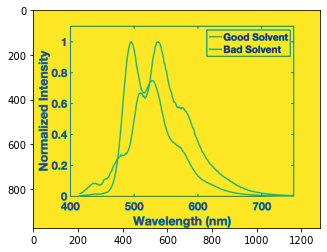

In [7]:
img=cv2.imread('/Users/livi/Git/Image-Processing/Bulk Spectra.tif',0)
plt.imshow(img)

In [8]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'
output=pytesseract.image_to_string(img, config=custom_config)
print(output)

:
> —Bad Solvent
2
20.8
o
—
£
5 0.6
o
.N
0.4
£
O
z 0.2

0 —

400 500 600 700

Wavelength (nm)



In [9]:
results = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)


In [10]:
'''# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image to be OCR'd")
ap.add_argument("-c", "--min-conf", type=int, default=0,
	help="mininum confidence value to filter weak text detection")
args = vars(ap.parse_args())
'''

usage: ipykernel_launcher.py [-h] -i IMAGE [-c MIN_CONF]
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


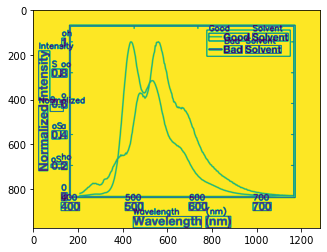

In [12]:
# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(results["conf"][i])
    # filter out weak confidence text localizations
	if conf > 99:#args["min_conf"]:
		# display the confidence and text to our terminal
		print("Confidence: {}".format(conf))
		print("Text: {}".format(text))
		print("")
		# strip out non-ASCII text so we can draw the text on the image
		# using OpenCV, then draw a bounding box around the text along
		# with the text itself
		text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
		cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
		cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
			1.2, (0, 0, 255), 3)
# show the output image
plt.imshow(img)

### Image Segmentation

In [ ]:
img=cv2.imread('/Users/livi/Git/Image-Processing/Bulk Spectra.tif',0)

In [ ]:
#Denoise for better results
#from skimage.restoration import denoise_tv_chambolle
#denoised_img=denoise_cv_chambolle(img, weight=0.1, eps=0.0002, n_iter_max=200)
#plt.imshow(img,cmap='gray')
A=plt.hist(img.flat,bins=100,range=(0,255))

In [ ]:
#devide image into different regions
thresholds=threshold_multiotsu(img,classes=3)
regions=np.digitize(img,bins=thresholds)

In [ ]:
plt.imshow(regions)

In [ ]:
outbox=regions==0
line=regions==1

In [ ]:
from scipy import ndimage as nd
for type in [outbox,line]:
    outbox_open=nd.binary_opening(type, np.ones((3,3)))
    outbox_close=nd.binary_closing(outbox_open,np.ones((3,3)))
    plt.imshow(outbox_close)
    plt.show()



In [ ]:
white_board=np.zeros((img.shape[0],img.shape[1]))
white_board[regions==0]=1
plt.imshow(white_board)